![](https://www.futuretimeline.net/blog/images/1466-chest-xray-ai-technology.jpg)

<p style='text-align: center;'><span style="color: #0D0D0D; font-family: Segoe UI; font-size: 2.6em; font-weight: 300;">VINBIGDATA - FUSING BBOXES + BUILDING COCO DATASET</span></p>




<span style="color: #ae1400; Segoe UI; font-size: 2.0em; font-weight: 300;">Overview</span>

<p style='text-align: justify;'><span style="font-family: Trebuchet MS; font-size: 1.2em;"> This notebook explores the different ways to select or fuse multiple bboxes of the same chest abnormality, annotated by several radiologists</span></p>

<p style='text-align: justify;'><span style="font-family: Trebuchet MS; font-size: 1.2em;"> It also covers the conversion of custom bbox annotations to the COCO format for frameworks such as TensorFlow Object Detection API, Detectron2 etc</span></p>


**A few key intricacies in this competetion includes the way the training data is provided. To state a few:** 

- **The abnormalities are labelled by multiple radiologists and there seems to be multiple bounding boxes for some abnormalities.**

- **Another issue being that some dense abnormality/lesion area may contain multiple labels. The radiologists creates boxes and then they may assign many labels to a single bounding box. This was stated by one of the competetion hosts.**

So the challenge of this competetion includes handling these issues before or after model training.Some ways to handle this would be to use suppression, selection or fusion techniques below which are covered in this notebook:

- **Non-maximum Suppression (NMS)**
- **Soft-NMS**
- **Non-maximum Weighted (NMW)**
- **Weighted Bboxes Fusion (WBF)**



These are generally used after model scoring to get to a consensus of a bounding box where the abnormality is based on the confidence scores, weightage of different models (if ensembling is used) etc.

Here, the challenge lies in the fact that we don't have confidence scores or metrics to assign weightage to the multiple annotations by radiologists. So all radiologists are treated equally and the suppression or fusion of bounding boxes has to be done with these factors out of the picture. This seems to show a behaviour by which the bounding boxes which appear alone, seems to get suppressed. This issue is handled in this notebook by separating out single bounding boxes before any technique is applied.

**Finally, please feel free to suggest any other novel methods to address these issues. Hope everyone finds this useful!**



<br />
<br />


<p style='text-align: justify;'><span style="color: #ae1400; Segoe UI; font-size: 1.2em; font-weight: 300;">Check out the training notebook which uses the COCO dataset generated here. It explains the Installation, Data preparation, Training and Inference using the TF2 Object Detection API for EfficientDet models. It can be adapted to various other models with just 1-2 lines of code change.</span></p>


<p style='text-align: justify;'><span style="font-family: Trebuchet MS; font-size: 1.1em;">VBD EfficientDET TF2 Object Detection API⚡📈</span></p>


TRAINING NOTEBOOK - https://www.kaggle.com/sreevishnudamodaran/vbd-efficientdet-tf2-object-detection-api

<br />
<br />

<p style='text-align: justify;'><span style="color: #ae1400; Segoe UI; font-size: 1.2em; font-weight: 300;">The COCO dataset with Fused Boxes generated as a part of this notebook is public. Please do check it out.</span></p>


<p style='text-align: justify;'><span style="font-family: Trebuchet MS; font-size: 1.1em;">VinBigData - Coco Dataset with WBF 3x Downscaled</span></p>


DATASET LINK - https://www.kaggle.com/sreevishnudamodaran/vinbigdata-coco-dataset-with-wbf-3x-downscaled

**Please note that only images with Chest Abnormalities are present in this dataset.**

<br />
<br />

**Class Mapping in the Annotations File:**

    0 - Aortic enlargement
    1 - Atelectasis
    2 - Calcification
    3 - Cardiomegaly
    4 - Consolidation
    5 - ILD
    6 - Infiltration
    7 - Lung Opacity
    8 - Nodule/Mass
    9 - Other lesion
    10 - Pleural effusion
    11 - Pleural thickening
    12 - Pneumothorax
    13 - Pulmonary fibrosis
 
 
### Citations:

**Thanks to [raddar](http://https://www.kaggle.com/raddar) for creating the 3x Downsampled Images which is used here:
https://www.kaggle.com/raddar/vinbigdata-competition-jpg-data-3x-downsampled**

**[Weighted Boxes Fusion: ensembling boxes for object detection models paper](https://arxiv.org/abs/1910.13302)**


<br />
<br />

[![Ask Me Anything !](https://img.shields.io/badge/Ask%20me-something-1abc9c.svg?style=flat-square&logo=kaggle)](https://www.kaggle.com/sreevishnudamodaran)
<br />

![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)

In [1]:
!pip install ensemble-boxes

In [18]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import cv2
import json
import pandas as pd
import glob
import os.path as osp
from path import Path
import datetime
import numpy as np
from tqdm import tqdm
import random
import shutil
from sklearn.model_selection import train_test_split

from ensemble_boxes import *
import warnings
from collections import Counter

## Loading the Annotation CSV

In [24]:
train_annotations = pd.read_csv("/home/hana/sonnh/kaggle-vin/dataset/images_only/train_only_box.csv")
image_basename = '714e4c788c40892e9a5500e4fde9c753'
train_annotations[train_annotations.image_id==image_basename]

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,fold
5,714e4c788c40892e9a5500e4fde9c753,Lung Opacity,7,R10,653.0,742.0,988.0,1333.0,1
807,714e4c788c40892e9a5500e4fde9c753,Cardiomegaly,3,R9,746.0,1428.0,1710.0,1776.0,1
5388,714e4c788c40892e9a5500e4fde9c753,Aortic enlargement,0,R9,1167.0,789.0,1428.0,1031.0,1
6398,714e4c788c40892e9a5500e4fde9c753,Pulmonary fibrosis,13,R8,548.0,503.0,1018.0,938.0,1
11656,714e4c788c40892e9a5500e4fde9c753,Pulmonary fibrosis,13,R10,510.0,545.0,944.0,917.0,1
12046,714e4c788c40892e9a5500e4fde9c753,Cardiomegaly,3,R8,759.0,1317.0,1720.0,1803.0,1
12730,714e4c788c40892e9a5500e4fde9c753,Consolidation,4,R9,605.0,898.0,969.0,1334.0,1
19024,714e4c788c40892e9a5500e4fde9c753,Aortic enlargement,0,R8,1196.0,810.0,1454.0,1230.0,1
19271,714e4c788c40892e9a5500e4fde9c753,Consolidation,4,R8,638.0,744.0,919.0,1302.0,1
30305,714e4c788c40892e9a5500e4fde9c753,Lung Opacity,7,R9,605.0,898.0,969.0,1334.0,1


In [25]:
train_annotations[train_annotations['image_id'] == '714e4c788c40892e9a5500e4fde9c753']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,fold
5,714e4c788c40892e9a5500e4fde9c753,Lung Opacity,7,R10,653.0,742.0,988.0,1333.0,1
807,714e4c788c40892e9a5500e4fde9c753,Cardiomegaly,3,R9,746.0,1428.0,1710.0,1776.0,1
5388,714e4c788c40892e9a5500e4fde9c753,Aortic enlargement,0,R9,1167.0,789.0,1428.0,1031.0,1
6398,714e4c788c40892e9a5500e4fde9c753,Pulmonary fibrosis,13,R8,548.0,503.0,1018.0,938.0,1
11656,714e4c788c40892e9a5500e4fde9c753,Pulmonary fibrosis,13,R10,510.0,545.0,944.0,917.0,1
12046,714e4c788c40892e9a5500e4fde9c753,Cardiomegaly,3,R8,759.0,1317.0,1720.0,1803.0,1
12730,714e4c788c40892e9a5500e4fde9c753,Consolidation,4,R9,605.0,898.0,969.0,1334.0,1
19024,714e4c788c40892e9a5500e4fde9c753,Aortic enlargement,0,R8,1196.0,810.0,1454.0,1230.0,1
19271,714e4c788c40892e9a5500e4fde9c753,Consolidation,4,R8,638.0,744.0,919.0,1302.0,1
30305,714e4c788c40892e9a5500e4fde9c753,Lung Opacity,7,R9,605.0,898.0,969.0,1334.0,1


## Selecting Images with Abnormalities

In [26]:
train_annotations = train_annotations[train_annotations.class_id!=14]
train_annotations['image_path'] = train_annotations['image_id'].map(lambda x:os.path.join('/home/hana/sonnh/kaggle-vin/dataset/images_only/train', str(x)+'.dicom.png'))
train_annotations.head(5)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,fold,image_path
0,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,1780.0,361.0,2047.0,612.0,4,/home/hana/sonnh/kaggle-vin/dataset/images_onl...
1,e7e8948818352b4d800dfac9a8999300,Pleural thickening,11,R9,599.0,303.0,885.0,366.0,4,/home/hana/sonnh/kaggle-vin/dataset/images_onl...
2,53e2a10eb9969b0e336a51d11dda17f9,Pleural thickening,11,R8,1838.0,370.0,2416.0,897.0,1,/home/hana/sonnh/kaggle-vin/dataset/images_onl...
3,5bf3368744630f459a499ccdccc9cdf1,Cardiomegaly,3,R10,1066.0,2026.0,2324.0,2586.0,0,/home/hana/sonnh/kaggle-vin/dataset/images_onl...
4,0f186e3eba8d9ebd51feed957204ddbf,Cardiomegaly,3,R8,1192.0,1695.0,2321.0,2009.0,1,/home/hana/sonnh/kaggle-vin/dataset/images_onl...


In [27]:
imagepaths = train_annotations['image_path'].unique()
print("Number of Images with abnormalities:",len(imagepaths))
anno_count = train_annotations.shape[0]
print("Number of Annotations with abnormalities:", anno_count)

Number of Images with abnormalities: 4394
Number of Annotations with abnormalities: 36096


## Helper Functions

In [12]:
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap='gray', img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_box = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return output

## Define Classes

In [13]:
labels =  [
            "__ignore__",
            "Aortic_enlargement",
            "Atelectasis",
            "Calcification",
            "Cardiomegaly",
            "Consolidation",
            "ILD",
            "Infiltration",
            "Lung_Opacity",
            "Nodule/Mass",
            "Other_lesion",
            "Pleural_effusion",
            "Pleural_thickening",
            "Pneumothorax",
            "Pulmonary_fibrosis"
            ]
viz_labels = labels[1:]

## Visualize Original Bboxes

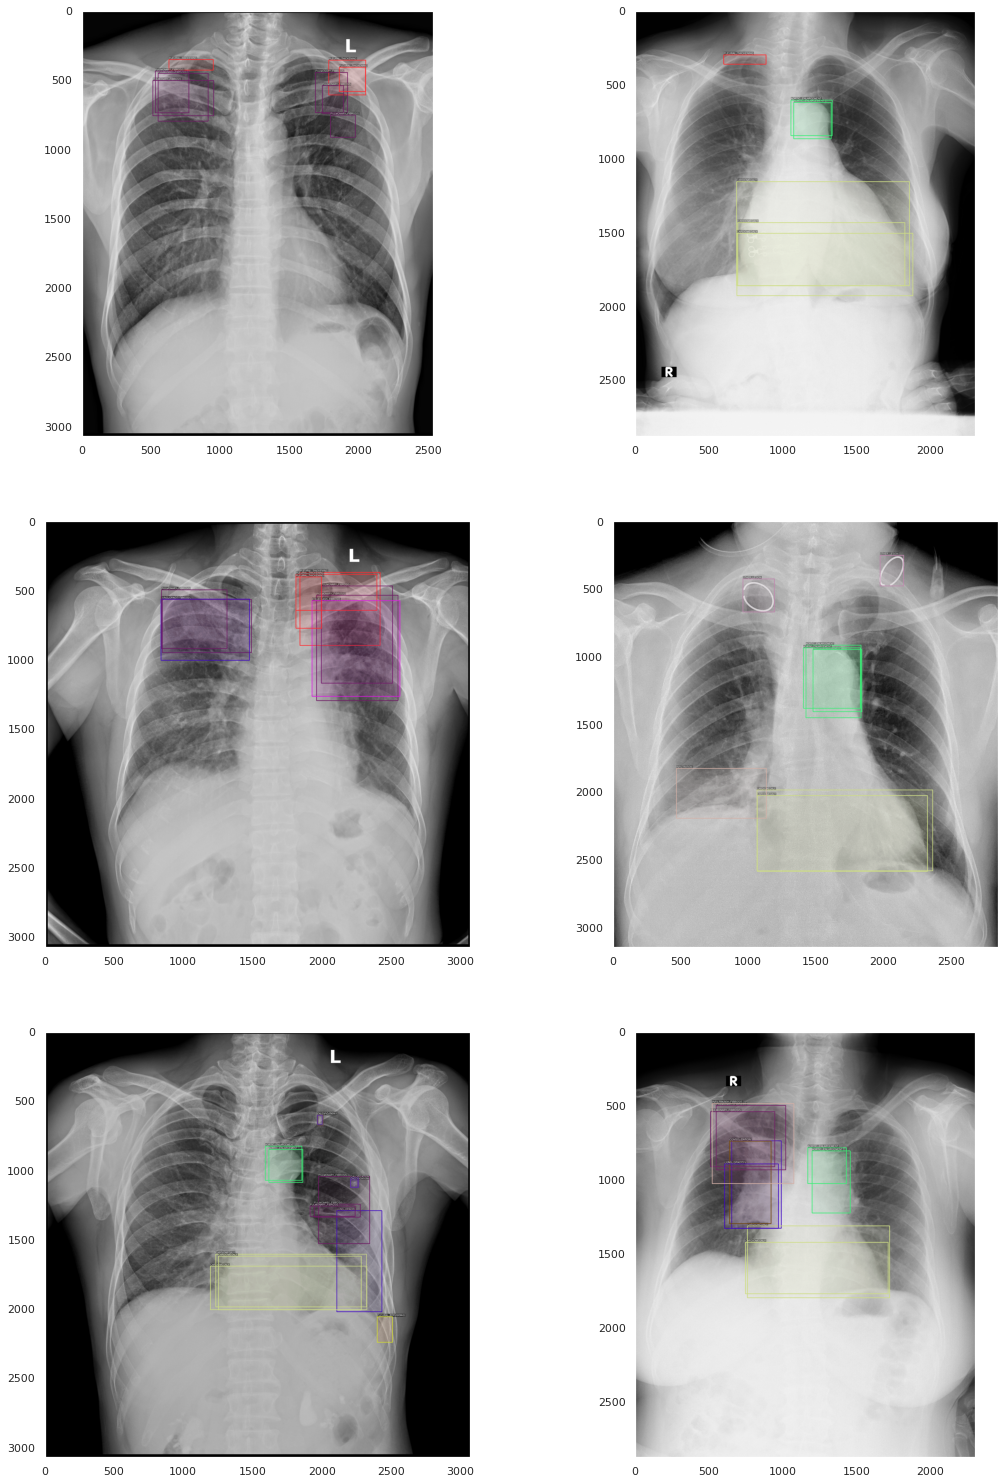

In [28]:
# map label_id to specify color
#label2color = [[random.randint(0,255) for i in range(3)] for class_id in viz_labels]
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]

thickness = 3
imgs = []

for img_id, path in zip(train_annotations['image_id'][:6], train_annotations['image_path'][:6]):

    boxes = train_annotations.loc[train_annotations['image_id'] == img_id,
                                  ['x_min', 'y_min', 'x_max', 'y_max']].values
    img_labels = train_annotations.loc[train_annotations['image_id'] == img_id, ['class_id']].values.squeeze()
    
    img = cv2.imread(path)
    
    for label_id, box in zip(img_labels, boxes):
        color = label2color[label_id]
        img = draw_bbox(img, list(np.int_(box)), viz_labels[label_id], color)
    imgs.append(img)

plot_imgs(imgs, size=9, cmap=None)
plt.show()

# Exploring Techniques to Combine Bboxes
## Non-maximum Suppression (NMS)

0it [00:00, ?it/s]

('714e4c788c40892e9a5500e4fde9c753.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/714e4c788c40892e9a5500e4fde9c753.dicom.png')
Bboxes before nms:
 [[653.0, 742.0, 988.0, 1333.0], [746.0, 1428.0, 1710.0, 1776.0], [1167.0, 789.0, 1428.0, 1031.0], [548.0, 503.0, 1018.0, 938.0], [510.0, 545.0, 944.0, 917.0], [759.0, 1317.0, 1720.0, 1803.0], [605.0, 898.0, 969.0, 1334.0], [1196.0, 810.0, 1454.0, 1230.0], [638.0, 744.0, 919.0, 1302.0], [605.0, 898.0, 969.0, 1334.0], [521.0, 490.0, 1073.0, 1031.0], [521.0, 490.0, 1073.0, 1031.0]]
Labels before nms:
 [7, 3, 0, 13, 13, 3, 4, 0, 4, 7, 13, 6]
Counter({13: 3, 7: 2, 3: 2, 0: 2, 4: 2, 6: 1})
Bboxes after nms:
 [[1196.0, 810.0, 1454.0, 1230.0], [1167.0, 789.0, 1428.0, 1031.0], [759.0, 1317.0, 1720.0, 1803.0], [638.0, 744.0, 919.0, 1302.0], [605.0, 898.0, 969.0, 1334.0], [521.0, 490.0, 1073.0, 1031.0], [521.0, 490.0, 1073.0, 1031.0]]
Labels after nms:
 [0, 0, 3, 4, 7, 13, 6]


1it [00:00,  2.91it/s]


('11b3a0fe7f25bbe7643c60bcb14c35f5.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/11b3a0fe7f25bbe7643c60bcb14c35f5.dicom.png')
Bboxes before nms:
 [[173.0, 993.0, 762.0, 2030.0], [1422.0, 1113.0, 1521.0, 1233.0], [1663.0, 1093.0, 1747.0, 1199.0], [440.0, 954.0, 553.0, 1076.0], [1729.0, 949.0, 1797.0, 1027.0], [483.0, 1756.0, 626.0, 1868.0], [220.0, 1678.0, 328.0, 1765.0], [309.0, 1506.0, 424.0, 1608.0], [337.0, 1147.0, 431.0, 1229.0], [1721.0, 1767.0, 1797.0, 1859.0], [1607.0, 844.0, 1910.0, 1909.0], [1129.0, 834.0, 1407.0, 1123.0], [661.0, 1025.0, 849.0, 1429.0], [372.0, 1290.0, 537.0, 1427.0], [379.0, 1690.0, 492.0, 1784.0], [281.0, 1786.0, 422.0, 1911.0], [1277.0, 790.0, 1544.0, 1066.0], [525.0, 1535.0, 633.0, 1650.0], [1718.0, 953.0, 1789.0, 1050.0], [1348.0, 796.0, 1539.0, 1088.0], [1362.0, 813.0, 1524.0, 1055.0], [574.0, 1109.0, 668.0, 1229.0]]
Labels before nms:
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Counter({8: 20, 0: 1, 9: 1})
Bbox

2it [00:01,  2.27it/s]


('92ec72f76087d45365e94f60cd667002.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/92ec72f76087d45365e94f60cd667002.dicom.png')
Bboxes before nms:
 [[1387.0, 498.0, 1708.0, 771.0], [903.0, 1190.0, 2007.0, 1466.0], [1404.0, 492.0, 1703.0, 788.0], [881.0, 1237.0, 2016.0, 1601.0], [886.0, 1199.0, 1929.0, 1516.0], [1378.0, 463.0, 1709.0, 878.0]]
Labels before nms:
 [0, 3, 0, 3, 3, 0]
Counter({0: 3, 3: 3})
Bboxes after nms:
 [[1378.0, 463.0, 1709.0, 878.0], [886.0, 1199.0, 1929.0, 1516.0]]
Labels after nms:
 [0, 3]


3it [00:01,  2.47it/s]

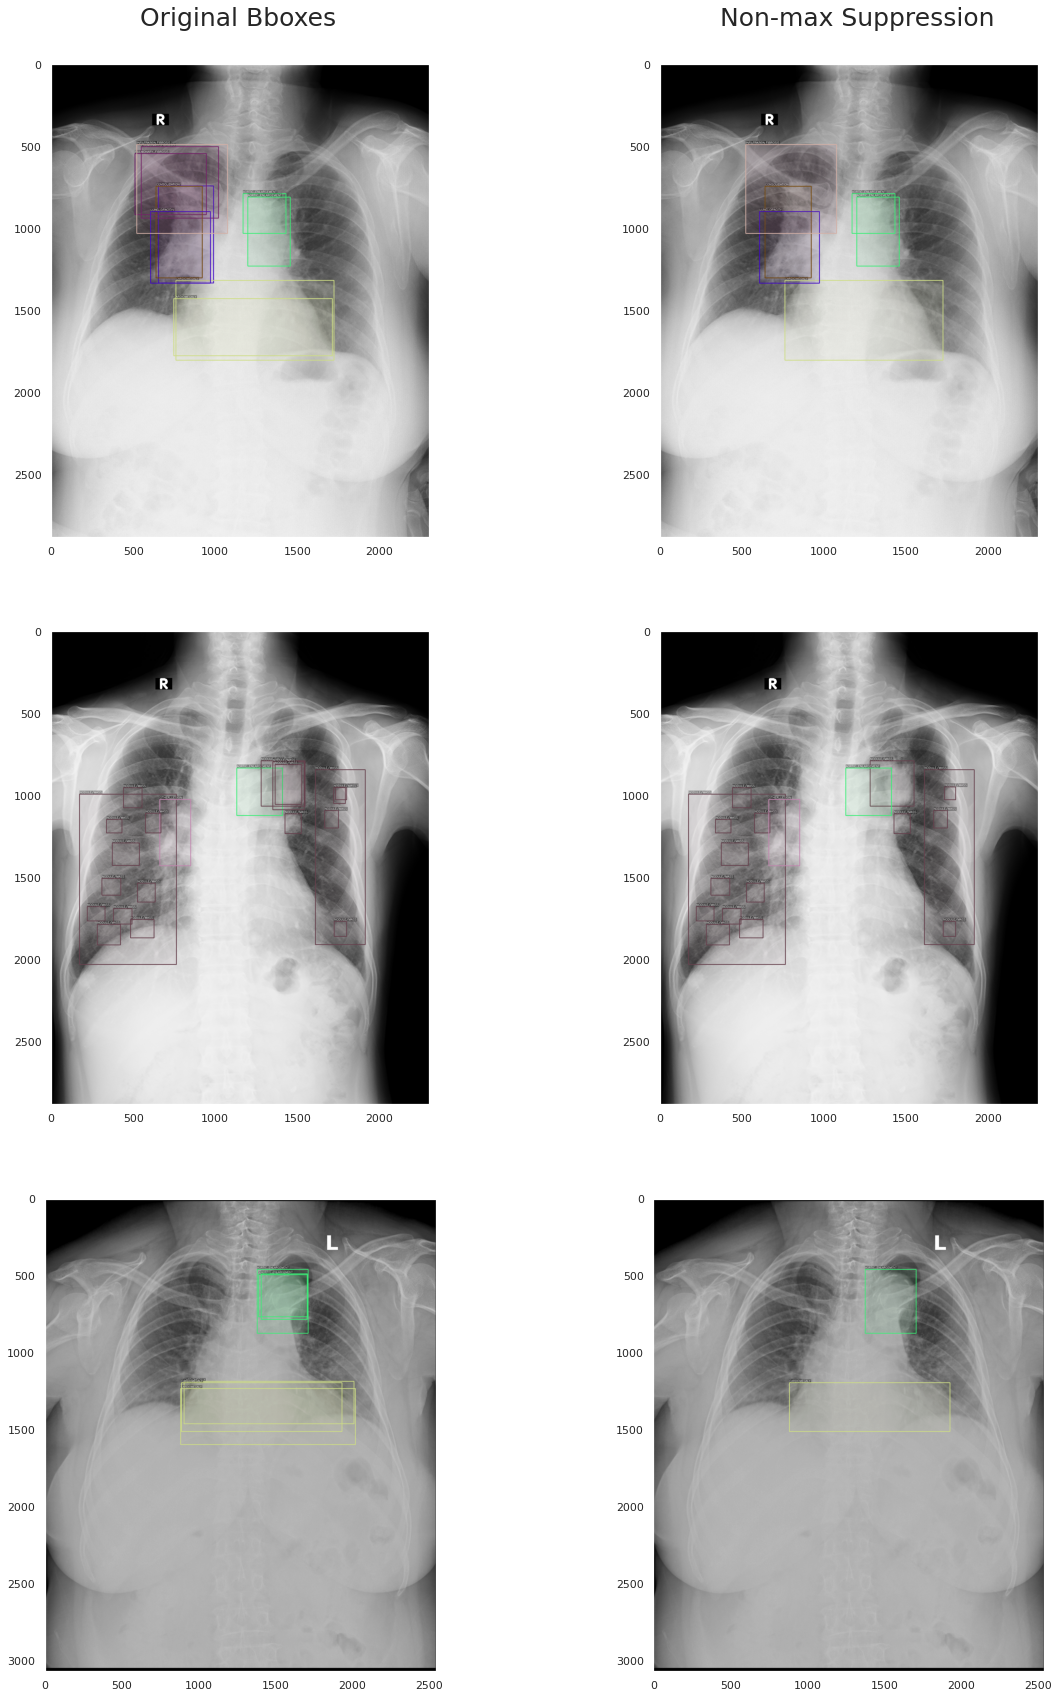

In [32]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename[:-6]]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    print("Bboxes before nms:\n", boxes_viz)
    print("Labels before nms:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            
    # Perform NMS
    boxes, scores, box_labels = nms(boxes_list, scores_list, labels_list, weights=weights,
                                    iou_thr=iou_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    print("Bboxes after nms:\n", boxes)
    print("Labels after nms:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"Non-max Suppression", va="top", ha="center", size=25)
plt.savefig('nms.png', bbox_inches='tight')
plt.show()

## Soft-NMS

0it [00:00, ?it/s]

('714e4c788c40892e9a5500e4fde9c753.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/714e4c788c40892e9a5500e4fde9c753.dicom.png')
Bboxes before soft_nms:
 [[653.0, 742.0, 988.0, 1333.0], [746.0, 1428.0, 1710.0, 1776.0], [1167.0, 789.0, 1428.0, 1031.0], [548.0, 503.0, 1018.0, 938.0], [510.0, 545.0, 944.0, 917.0], [759.0, 1317.0, 1720.0, 1803.0], [605.0, 898.0, 969.0, 1334.0], [1196.0, 810.0, 1454.0, 1230.0], [638.0, 744.0, 919.0, 1302.0], [605.0, 898.0, 969.0, 1334.0], [521.0, 490.0, 1073.0, 1031.0], [521.0, 490.0, 1073.0, 1031.0]]
Labels before soft_nms:
 [7, 3, 0, 13, 13, 3, 4, 0, 4, 7, 13, 6]
Counter({13: 3, 7: 2, 3: 2, 0: 2, 4: 2, 6: 1})
Bboxes after soft_nms:
 [[1167.0, 789.0, 1428.0, 1031.0], [1196.0, 810.0, 1454.0, 1230.0], [746.0, 1428.0, 1710.0, 1776.0], [759.0, 1317.0, 1720.0, 1803.0], [605.0, 898.0, 969.0, 1334.0], [638.0, 744.0, 919.0, 1302.0], [653.0, 742.0, 988.0, 1333.0], [605.0, 898.0, 969.0, 1334.0], [548.0, 503.0, 1018.0, 938.0], [510.0, 545.0, 944.0, 917.

1it [00:00,  2.33it/s]


('11b3a0fe7f25bbe7643c60bcb14c35f5.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/11b3a0fe7f25bbe7643c60bcb14c35f5.dicom.png')
Bboxes before soft_nms:
 [[173.0, 993.0, 762.0, 2030.0], [1422.0, 1113.0, 1521.0, 1233.0], [1663.0, 1093.0, 1747.0, 1199.0], [440.0, 954.0, 553.0, 1076.0], [1729.0, 949.0, 1797.0, 1027.0], [483.0, 1756.0, 626.0, 1868.0], [220.0, 1678.0, 328.0, 1765.0], [309.0, 1506.0, 424.0, 1608.0], [337.0, 1147.0, 431.0, 1229.0], [1721.0, 1767.0, 1797.0, 1859.0], [1607.0, 844.0, 1910.0, 1909.0], [1129.0, 834.0, 1407.0, 1123.0], [661.0, 1025.0, 849.0, 1429.0], [372.0, 1290.0, 537.0, 1427.0], [379.0, 1690.0, 492.0, 1784.0], [281.0, 1786.0, 422.0, 1911.0], [1277.0, 790.0, 1544.0, 1066.0], [525.0, 1535.0, 633.0, 1650.0], [1718.0, 953.0, 1789.0, 1050.0], [1348.0, 796.0, 1539.0, 1088.0], [1362.0, 813.0, 1524.0, 1055.0], [574.0, 1109.0, 668.0, 1229.0]]
Labels before soft_nms:
 [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Counter({8: 20, 0: 1, 9

2it [00:01,  1.97it/s]


('92ec72f76087d45365e94f60cd667002.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/92ec72f76087d45365e94f60cd667002.dicom.png')
Bboxes before soft_nms:
 [[1387.0, 498.0, 1708.0, 771.0], [903.0, 1190.0, 2007.0, 1466.0], [1404.0, 492.0, 1703.0, 788.0], [881.0, 1237.0, 2016.0, 1601.0], [886.0, 1199.0, 1929.0, 1516.0], [1378.0, 463.0, 1709.0, 878.0]]
Labels before soft_nms:
 [0, 3, 0, 3, 3, 0]
Counter({0: 3, 3: 3})
Bboxes after soft_nms:
 [[1387.0, 498.0, 1708.0, 771.0], [1378.0, 463.0, 1709.0, 878.0], [903.0, 1190.0, 2007.0, 1466.0], [881.0, 1237.0, 2016.0, 1601.0]]
Labels after soft_nms:
 [0, 0, 3, 3]


3it [00:01,  2.19it/s]

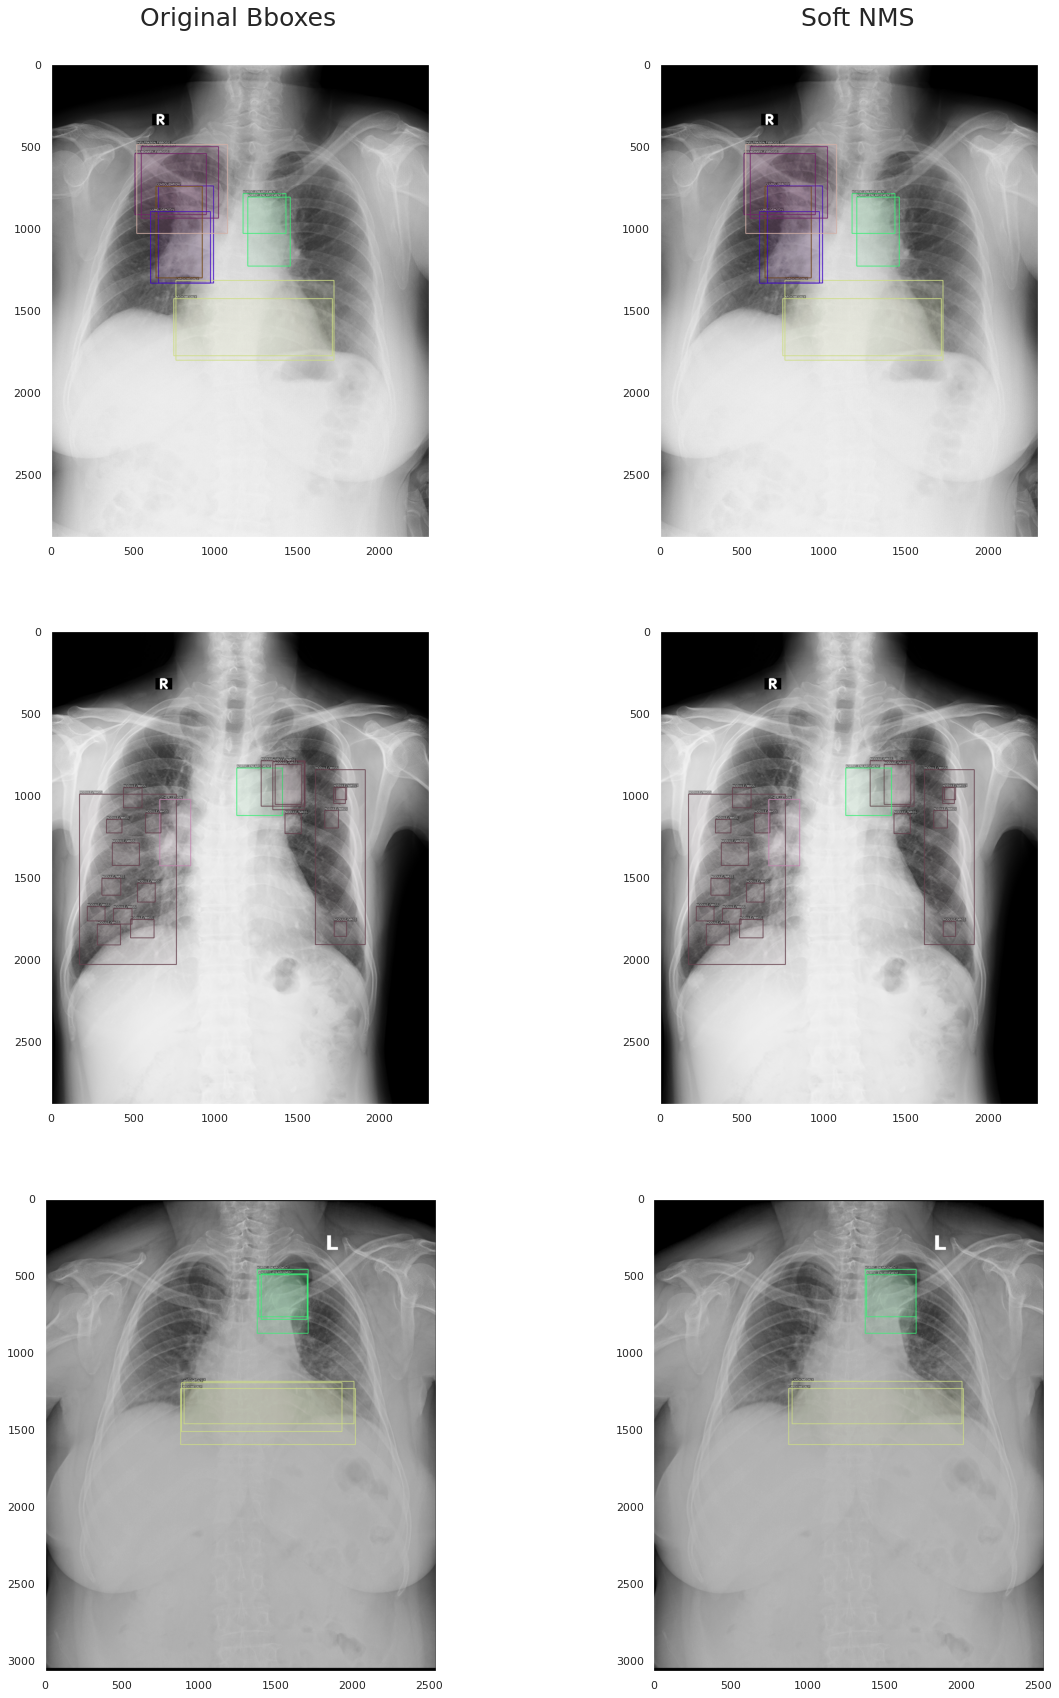

In [33]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
sigma = 0.1

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename[:-6]]
    
    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    print("Bboxes before soft_nms:\n", boxes_viz)
    print("Labels before soft_nms:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            
        
    # Perform Soft-NMS
    boxes, scores, box_labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights,
                                         iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
    
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()
    
    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    print("Bboxes after soft_nms:\n", boxes)
    print("Labels after soft_nms:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"Soft NMS", va="top", ha="center", size=25)
plt.savefig('snms.png', bbox_inches='tight')
plt.show()

## Non-maximum Weighted

0it [00:00, ?it/s]

('714e4c788c40892e9a5500e4fde9c753.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/714e4c788c40892e9a5500e4fde9c753.dicom.png')
Bboxes before non_maximum_weighted:
 [[653.0, 742.0, 988.0, 1333.0], [746.0, 1428.0, 1710.0, 1776.0], [1167.0, 789.0, 1428.0, 1031.0], [548.0, 503.0, 1018.0, 938.0], [510.0, 545.0, 944.0, 917.0], [759.0, 1317.0, 1720.0, 1803.0], [605.0, 898.0, 969.0, 1334.0], [1196.0, 810.0, 1454.0, 1230.0], [638.0, 744.0, 919.0, 1302.0], [605.0, 898.0, 969.0, 1334.0], [521.0, 490.0, 1073.0, 1031.0], [521.0, 490.0, 1073.0, 1031.0]]
Labels before non_maximum_weighted:
 [7, 3, 0, 13, 13, 3, 4, 0, 4, 7, 13, 6]
Counter({13: 3, 7: 2, 3: 2, 0: 2, 4: 2, 6: 1})


1it [00:00,  2.22it/s]

Bboxes after non_maximum_weighted:
 [[626.1, 799.4, 937.0, 1313.5], [526.8, 507.0, 1025.5, 975.2], [1167.0, 789.0, 1428.0, 1031.0], [1196.0, 810.0, 1454.0, 1230.0], [753.6, 1362.8, 1715.9, 1791.9], [623.5, 837.9, 976.3, 1333.6], [521.0, 490.0, 1073.0, 1031.0]]
Labels after non_maximum_weighted:
 [4, 13, 0, 0, 3, 7, 6]

('11b3a0fe7f25bbe7643c60bcb14c35f5.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/11b3a0fe7f25bbe7643c60bcb14c35f5.dicom.png')
Bboxes before non_maximum_weighted:
 [[173.0, 993.0, 762.0, 2030.0], [1422.0, 1113.0, 1521.0, 1233.0], [1663.0, 1093.0, 1747.0, 1199.0], [440.0, 954.0, 553.0, 1076.0], [1729.0, 949.0, 1797.0, 1027.0], [483.0, 1756.0, 626.0, 1868.0], [220.0, 1678.0, 328.0, 1765.0], [309.0, 1506.0, 424.0, 1608.0], [337.0, 1147.0, 431.0, 1229.0], [1721.0, 1767.0, 1797.0, 1859.0], [1607.0, 844.0, 1910.0, 1909.0], [1129.0, 834.0, 1407.0, 1123.0], [661.0, 1025.0, 849.0, 1429.0], [372.0, 1290.0, 537.0, 1427.0], [379.0, 1690.0, 492.0, 1784.0], [281.0, 178

2it [00:01,  1.95it/s]


('92ec72f76087d45365e94f60cd667002.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/92ec72f76087d45365e94f60cd667002.dicom.png')
Bboxes before non_maximum_weighted:
 [[1387.0, 498.0, 1708.0, 771.0], [903.0, 1190.0, 2007.0, 1466.0], [1404.0, 492.0, 1703.0, 788.0], [881.0, 1237.0, 2016.0, 1601.0], [886.0, 1199.0, 1929.0, 1516.0], [1378.0, 463.0, 1709.0, 878.0]]
Labels before non_maximum_weighted:
 [0, 3, 0, 3, 3, 0]
Counter({0: 3, 3: 3})
Bboxes after non_maximum_weighted:
 [[890.0, 1206.3, 1976.9, 1523.0], [1387.9, 481.0, 1707.0, 822.7]]
Labels after non_maximum_weighted:
 [3, 0]


3it [00:01,  2.24it/s]

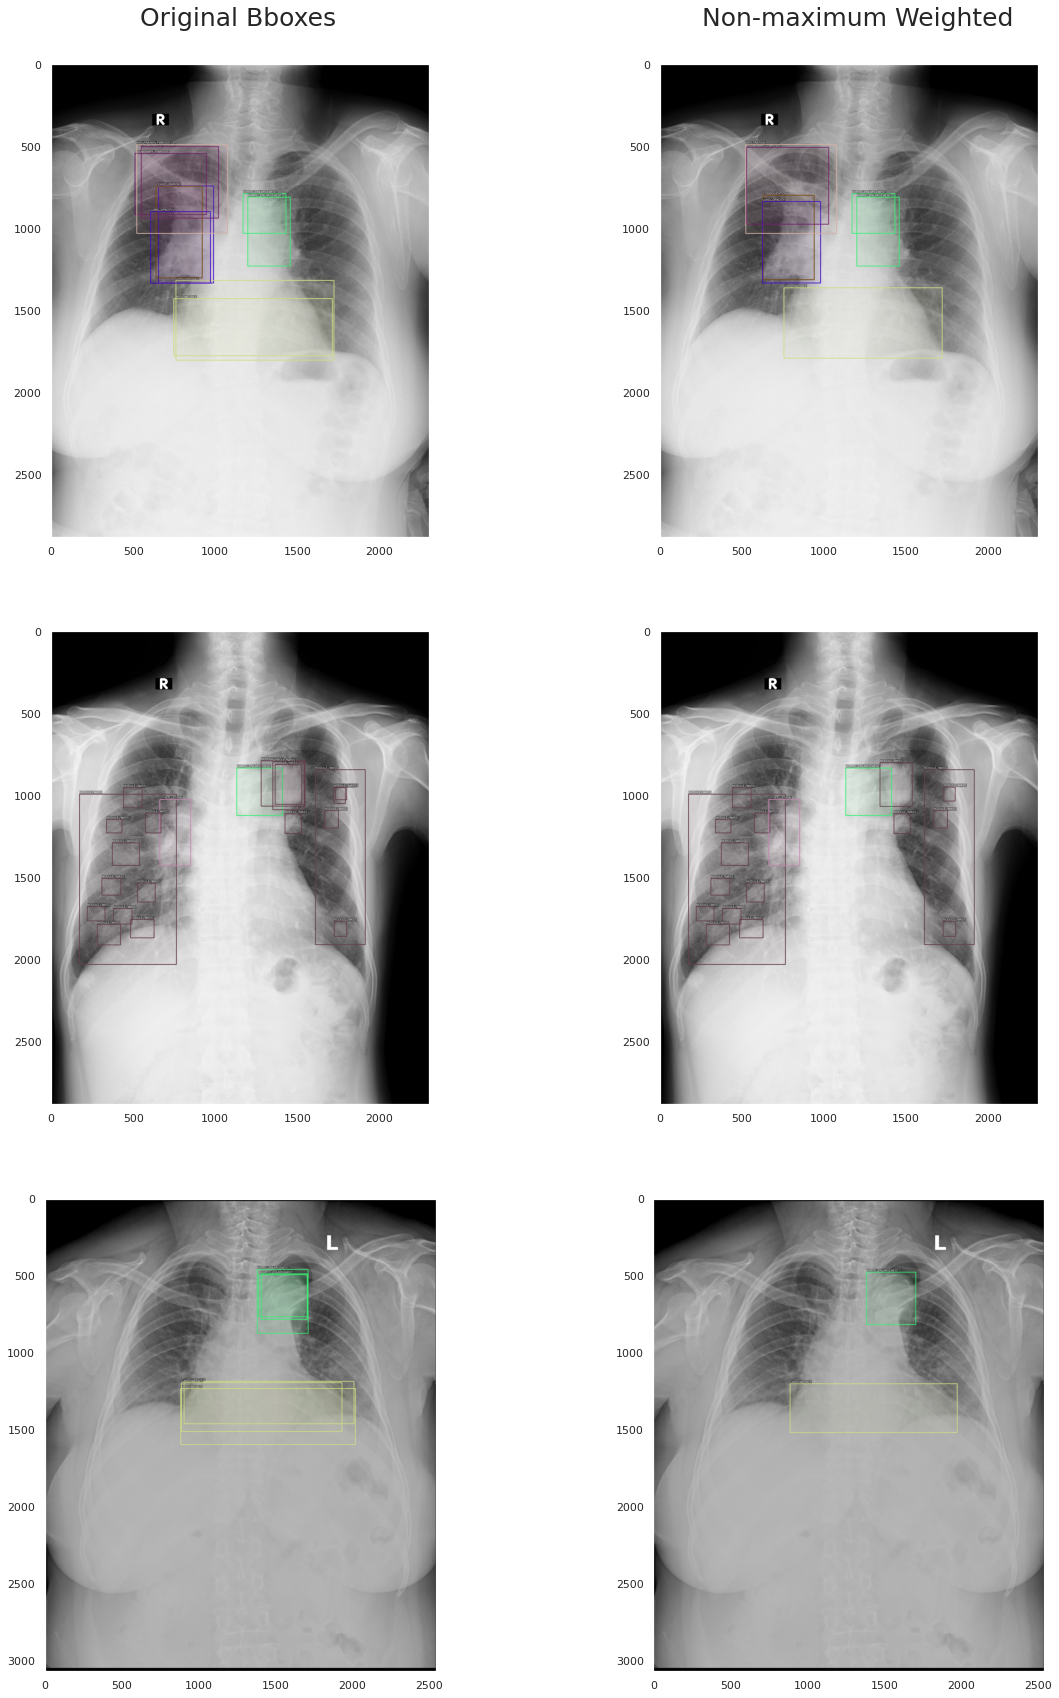

In [34]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename[:-6]]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    print("Bboxes before non_maximum_weighted:\n", boxes_viz)
    print("Labels before non_maximum_weighted:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            

    # Perform Non-maximum Weighted
    boxes, scores, box_labels = non_maximum_weighted(boxes_list, scores_list, labels_list,
                                                     weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    print("Bboxes after non_maximum_weighted:\n", boxes)
    print("Labels after non_maximum_weighted:\n", box_labels)
    
    ## Visualize Bboxes after operation
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        color = label2color[int(label)]
        img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_after)
    print()
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"Non-maximum Weighted", va="top", ha="center", size=25)
plt.savefig('nmw.png', bbox_inches='tight')
plt.show()

## Weighted boxes fusion (WBF)

In [39]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
sigma = 0.1

for i, path in tqdm(enumerate(imagepaths[5:8])):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
    print(f"(\'{image_basename}\', \'{path}\')")
    img_annotations = train_annotations[train_annotations.image_id==image_basename[:-6]]
    
    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
#     print("Bboxes before WBF:\n", boxes_viz)
#     print("Labels before WBF:\n", labels_viz)
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes_viz, labels_viz):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[int(label)]
        img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
    viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
#     print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            

    # Perform WBF
    boxes, scores, box_labels= weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights,
                                                     iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    
#     print("Bboxes after WBF:\n", boxes)
#     print("Labels after WBF:\n", box_labels)
    
#     ## Visualize Bboxes after operation
#     img_after = img_array.copy()
#     for box, label in zip(boxes, box_labels):
#         color = label2color[int(label)]
#         img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
#     viz_images.append(img_after)
#     print()
        
# plot_imgs(viz_images, cmap=None)
# plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
# plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
# plt.savefig('wbf.png', bbox_inches='tight')
# plt.show()

1it [00:00,  4.00it/s]

('714e4c788c40892e9a5500e4fde9c753.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/714e4c788c40892e9a5500e4fde9c753.dicom.png')
[[1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0]]
('11b3a0fe7f25bbe7643c60bcb14c35f5.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/11b3a0fe7f25bbe7643c60bcb14c35f5.dicom.png')


3it [00:00,  3.79it/s]

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
('92ec72f76087d45365e94f60cd667002.dicom', '/home/hana/sonnh/kaggle-vin/dataset/images_only/train/92ec72f76087d45365e94f60cd667002.dicom.png')
[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]


### Weighted Boxes Fusion seems to give  gives better results comparing to others in this situation considering that we don't have the confidence/weights of the annotations done by different radiologists

# Building COCO DATASET
## Train & Validation Split

In [ ]:
random.seed(42)
## 42 -  The Answer to the Ultimate Question of Life
random.shuffle(imagepaths)
train_len = round(0.75*len(imagepaths))
train_paths = imagepaths[:train_len]
val_paths = imagepaths[train_len:]

print("Split Counts\nTrain Images:\t\t{0}\nVal Images:\t\t{1}"
      .format(len(train_paths), len(val_paths)))

## COCO Format Overview
### Basic Syntax





```python
{
  "type": "instances",
  "images": [
    {
      "file_name": "<image_name.jpg>",
      "height": "<height>",
      "width": "<width>",
      "id": "<Used to reference each image and it should be unique for each image. This will be the 'image_id' used to tag each annotation>"
    }
#    .
#    .
#    .
      
  ],

  "categories": [
    {
      "supercategory": "none",
      "name": "<Class One>",
      "id": 0
    },
    {
      "supercategory": "none",
      "name": "<Class Two>",
      "id": 2
    }
#    .
#    .
#    .

  ],

  "annotations": [
    {
      "id": 1,
      "bbox": [
        "<xmin>",
        "<ymin>",
        "<bbox-width>",
        "<bbox-height>"
      ],
      "image_id": "<id of the image from which the polygon annotation is from as defined in the 'images' block above>",

      "segmentation": [
          "<x1>",
          "<y1>",
          "<x2>",
          "<y2>"
#          .
#          .
#          .

      ],
      "ignore": 0,
      "area": "<Area of the Polygon represented by the points in 'segmentation' block>",
      "iscrowd": 0,
      "category_id": "<Class category ID as an integer which will be defined below>"
    },

  ],
"categories": [
    {
        "supercategory": null,
        "id": "<Integer ID for the Class Label>",
        "name": "<Class One Label as a String>"
    },
#    .
#    .
#    .

]
}
```

## Defining Structure

In [ ]:
now = datetime.datetime.now()

data = dict(
    info=dict(
        description=None,
        url=None,
        version=None,
        year=now.year,
        contributor=None,
        date_created=now.strftime('%Y-%m-%d %H:%M:%S.%f'),
    ),
    licenses=[dict(
        url=None,
        id=0,
        name=None,
    )],
    images=[
        # license, url, file_name, height, width, date_captured, id
    ],
    type='instances',
    annotations=[
        # segmentation, area, iscrowd, image_id, bbox, category_id, id
    ],
    categories=[
        # supercategory, id, name
    ],
)

In [ ]:
class_name_to_id = {}
for i, each_label in enumerate(labels):
    class_id = i - 1  # starts with -1
    class_name = each_label
    if class_id == -1:
        assert class_name == '__ignore__'
        continue
    class_name_to_id[class_name] = class_id
    data['categories'].append(dict(
        supercategory=None,
        id=class_id,
        name=class_name,
    ))

## Data Dict Before Adding Annotations

In [ ]:
data

## Creating The Output Directories

In [ ]:
# !rm -r ./vinbigdata_coco_chest_xray

In [ ]:
train_output_dir = "./vinbigdata_coco_chest_xray/train_images"
val_output_dir = "./vinbigdata_coco_chest_xray/val_images"

if not osp.exists(train_output_dir):
    os.makedirs(train_output_dir)
    print('Coco Train Image Directory:', train_output_dir)
    
if not osp.exists(val_output_dir):
    os.makedirs(val_output_dir)
    print('Coco Val Image Directory:', val_output_dir)

# Coco Conversion Job
## Prepare the Training Set

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
## Setting the output annotations json file path
train_out_file = './vinbigdata_coco_chest_xray/train_annotations.json'

data_train = data.copy()
data_train['images'] = []
data_train['annotations'] = []

In [ ]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i, path in tqdm(enumerate(train_paths)):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
#     print(f"(\'{image_basename}\', \'{path}\')")
    
    ## Copy Image 
    shutil.copy2(path, train_output_dir)
    
    ## Add Images to annotation
    data_train['images'].append(dict(
        license=0,
        url=None,
        file_name=os.path.join('train_images', image_basename+'.jpg'),
        height=img_array.shape[0],
        width=img_array.shape[1],
        date_captured=None,
        id=i
    ))
    
    img_annotations = train_annotations[train_annotations.image_id==image_basename]
    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    ## Visualize Original Bboxes every 500th
    if (i%500==0):
        img_before = img_array.copy()
        for box, label in zip(boxes_viz, labels_viz):
            x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
            color = label2color[int(label)]
            img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
        viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []

    cls_ids = img_annotations['class_id'].unique().tolist()
    
    count_dict = Counter(img_annotations['class_id'].tolist())

    for cid in cls_ids:
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())
            weights.append(1)
    
    ## Perform WBF
    boxes, scores, box_labels = weighted_boxes_fusion(boxes_list=boxes_list, scores_list=scores_list,
                                                  labels_list=labels_list, weights=weights,
                                                  iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()
    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        area = round((x_max-x_min)*(y_max-y_min),1)
        bbox =[
                round(x_min, 1),
                round(y_min, 1),
                round((x_max-x_min), 1),
                round((y_max-y_min), 1)
                ]
        
        data_train['annotations'].append(dict( id=len(data_train['annotations']), image_id=i,
                                            category_id=int(label), area=area, bbox=bbox,
                                            iscrowd=0))
        
    ## Visualize Bboxes after operation every 500th
    if (i%500==0):
        img_after = img_array.copy()
        for box, label in zip(boxes, box_labels):
            color = label2color[int(label)]
            img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
        viz_images.append(img_after)

plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
plt.show()
               
with open(train_out_file, 'w') as f:
    json.dump(data_train, f, indent=4)

## Prepare the Validation Set

In [ ]:
## Setting the output annotations json file path
val_out_file = './vinbigdata_coco_chest_xray/val_annotations.json'

data_val = data.copy()
data_val['images'] = []
data_val['annotations'] = []

In [ ]:
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []

for i, path in tqdm(enumerate(val_paths)):
    img_array  = cv2.imread(path)
    image_basename = Path(path).stem
#     print(f"(\'{image_basename}\', \'{path}\')")
    
    ## Copy Image 
    shutil.copy2(path, val_output_dir)
    
    ## Add Images to annotation
    data_val['images'].append(dict(
        license=0,
        url=None,
        file_name=os.path.join('val_images', image_basename+'.jpg'),
        height=img_array.shape[0],
        width=img_array.shape[1],
        date_captured=None,
        id=i
    ))
    
    img_annotations = train_annotations[train_annotations.image_id==image_basename]
    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    ## Visualize Original Bboxes every 500th
    if (i%500==0):
        img_before = img_array.copy()
        for box, label in zip(boxes_viz, labels_viz):
            x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
            color = label2color[int(label)]
            img_before = draw_bbox(img_before, list(np.int_(box)), viz_labels[label], color)
        viz_images.append(img_before)
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []

    cls_ids = img_annotations['class_id'].unique().tolist()
    
    count_dict = Counter(img_annotations['class_id'].tolist())
    for cid in cls_ids:
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())
            weights.append(1)
            
    ## Perform WBF
    boxes, scores, box_labels = weighted_boxes_fusion(boxes_list=boxes_list, scores_list=scores_list,
                                                  labels_list=labels_list, weights=weights,
                                                  iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    boxes = boxes*(img_array.shape[1], img_array.shape[0], img_array.shape[1], img_array.shape[0])
    boxes = boxes.round(1).tolist()
    box_labels = box_labels.astype(int).tolist()
    boxes.extend(boxes_single)
    box_labels.extend(labels_single)
    
    img_after = img_array.copy()
    for box, label in zip(boxes, box_labels):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        area = round((x_max-x_min)*(y_max-y_min),1)
        bbox =[
                round(x_min, 1),
                round(y_min, 1),
                round((x_max-x_min), 1),
                round((y_max-y_min), 1)
                ]
        
        data_val['annotations'].append(dict( id=len(data_val['annotations']), image_id=i,
                                            category_id=int(label), area=area, bbox=bbox,
                                            iscrowd=0))
        
    ## Visualize Bboxes after operation
    if (i%500==0):
        img_after = img_array.copy()
        for box, label in zip(boxes, box_labels):
            color = label2color[int(label)]
            img_after = draw_bbox(img_after, list(np.int_(box)), viz_labels[label], color)
        viz_images.append(img_after)
        
plot_imgs(viz_images, cmap=None)
plt.figtext(0.3, 0.9,"Original Bboxes", va="top", ha="center", size=25)
plt.figtext(0.73, 0.9,"WBF", va="top", ha="center", size=25)
plt.show()
               
with open(val_out_file, 'w') as f:
    json.dump(data_val, f, indent=4)

## Verify Annotaions

In [ ]:
print("Number of Images in the Train Annotations File:", len(data_train['images']))
print("Number of Bboxes in the Train Annotations File:", len(data_train['annotations']))

print("Number of Images in the Val Annotations File:", len(data_val['images']))
print("Number of Bboxes in the Val Annotations File:", len(data_val['annotations']))

## Converted Example with 2 Images

```python
{
    "info": {
        "description": null,
        "url": null,
        "version": null,
        "year": 2021,
        "contributor": null,
        "date_created": "2021-01-12 13:26:45.546865"
    },
    "licenses": [
        {
            "url": null,
            "id": 0,
            "name": null
        }
    ],
    "images": [
        {
            "license": 0,
            "url": null,
            "file_name": "val_images/a5ef63166c0cc0acf772a7f06ef54fac.jpg",
            "height": 997,
            "width": 956,
            "date_captured": null,
            "id": 0
        },
        {
            "license": 0,
            "url": null,
            "file_name": "val_images/02acf0e7d0932f9c6a06fd4bbe1f5d90.jpg",
            "height": 1024,
            "width": 1024,
            "date_captured": null,
            "id": 1
        }
    ],
    "type": "instances",
    "annotations": [
        {
            "id": 0,
            "image_id": 0,
            "category_id": 0,
            "area": 15507.8,
            "bbox": [
                496.3,
                300.7,
                106.0,
                146.3
            ],
            "iscrowd": 0
        },
        {
            "id": 1,
            "image_id": 0,
            "category_id": 3,
            "area": 55841.5,
            "bbox": [
                360.0,
                567.5,
                390.5,
                143.0
            ],
            "iscrowd": 0
        },
        {
            "id": 2,
            "image_id": 0,
            "category_id": 7,
            "area": 9146.2,
            "bbox": [
                345.5,
                485.5,
                67.5,
                135.5
            ],
            "iscrowd": 0
        },
        {
            "id": 3,
            "image_id": 1,
            "category_id": 3,
            "area": 36659.7,
            "bbox": [
                384.7,
                468.0,
                370.3,
                99.0
            ],
            "iscrowd": 0
        },
        {
            "id": 4,
            "image_id": 1,
            "category_id": 0,
            "area": 12193.3,
            "bbox": [
                535.0,
                207.7,
                99.7,
                122.3
            ],
            "iscrowd": 0
        },
        {
            "id": 5,
            "image_id": 1,
            "category_id": 9,
            "area": 13837.0,
            "bbox": [
                453.0,
                217.0,
                137.0,
                101.0
            ],
            "iscrowd": 0
        }
    ],
    "categories": [
        {
            "supercategory": null,
            "id": 0,
            "name": "Aortic_enlargement"
        },
        {
            "supercategory": null,
            "id": 1,
            "name": "Atelectasis"
        },
        {
            "supercategory": null,
            "id": 2,
            "name": "Calcification"
        },
        {
            "supercategory": null,
            "id": 3,
            "name": "Cardiomegaly"
        },
        {
            "supercategory": null,
            "id": 4,
            "name": "Consolidation"
        },
        {
            "supercategory": null,
            "id": 5,
            "name": "ILD"
        },
        {
            "supercategory": null,
            "id": 6,
            "name": "Infiltration"
        },
        {
            "supercategory": null,
            "id": 7,
            "name": "Lung_Opacity"
        },
        {
            "supercategory": null,
            "id": 8,
            "name": "Nodule/Mass"
        },
        {
            "supercategory": null,
            "id": 9,
            "name": "Other_lesion"
        },
        {
            "supercategory": null,
            "id": 10,
            "name": "Pleural_effusion"
        },
        {
            "supercategory": null,
            "id": 11,
            "name": "Pleural_thickening"
        },
        {
            "supercategory": null,
            "id": 12,
            "name": "Pneumothorax"
        },
        {
            "supercategory": null,
            "id": 13,
            "name": "Pulmonary_fibrosis"
        }
    ]
}
```

### Verify Number of Files 

In [ ]:
!find ./vinbigdata_coco_chest_xray/val_images -type f | wc -l

In [ ]:
!find ./vinbigdata_coco_chest_xray/train_images -type f | wc -l

### Packaging Dataset into Zip for Upload

In [ ]:
%%bash
cd ./vinbigdata_coco_chest_xray
zip -r ../vinbigdata-coco-dataset-with-wbf-3x-downscaled.zip ./*

In [ ]:
%%bash
rm -r ./vinbigdata_coco_chest_xray
ls -ahl

<p style='text-align: center;'><span style="color: #0D0D0D; font-family: Segoe UI; font-size: 2.0em; font-weight: 300;">THANK YOU! PLEASE UPVOTE</span></p>

<p style='text-align: center;'><span style="color: #0D0D0D; font-family: Segoe UI; font-size: 2.5em; font-weight: 300;">HOPE IT WAS USEFUL</span></p>

<p style='text-align: center;'><span style="color: #009BAE; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Check out the Train Notebook below</span></p>



<p style='text-align: center;'><span style="font-family: Trebuchet MS; font-size: 1.3em;"><a href="https://www.kaggle.com/sreevishnudamodaran/vbd-efficientdet-tf2-object-detection-api" target="_top">VBD EfficientDET TF2 Object Detection API⚡📈</a></span></p>

<p style='text-align: center;'></p>
